In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

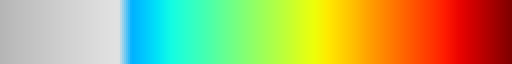

In [4]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 10))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 30))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
year = 2014
dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/')
data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))

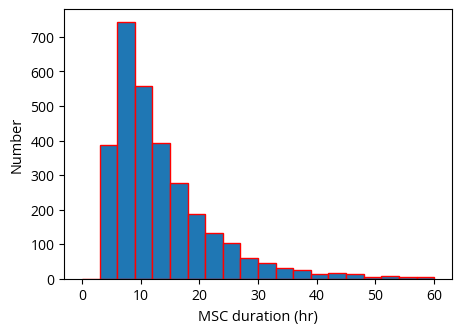

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ax.hist(data_track.mcs_duration, bins=20, range=(0,60), edgecolor="red")
ax.set_ylabel('Number', fontsize=10.5)
ax.set_xlabel('MSC duration (hr)', fontsize=10.5);

CPU times: user 15.2 s, sys: 233 ms, total: 15.4 s
Wall time: 15.4 s


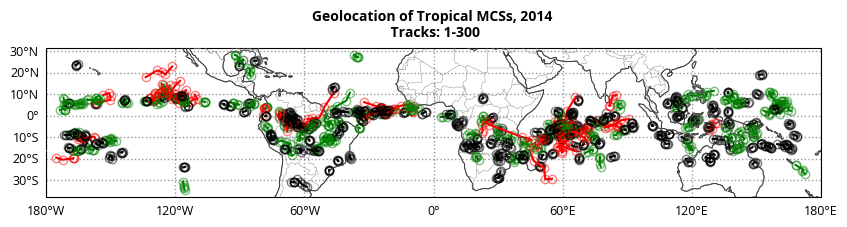

In [7]:
%%time
fig, ax = plt.subplots(1,1,figsize=(10,6),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plotting section
for track in data_track.tracks[:300].values:
    
    data_track_sub = data_track.sel(tracks=track)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]
    duration = data_track_sub.mcs_duration
    
    # edgecolor as duration indicator
    if duration < 12:
        ccolor = 'k'
    elif ( duration >= 12 ) and ( duration < 24 ):
        ccolor = 'g'
    else:
        ccolor = 'r'
    
    lon_traject = []
    lat_traject = []
    for idt in idt_phase:
    
        meanlon = data_track_sub.isel(times=idt).meanlon
        meanlat = data_track_sub.isel(times=idt).meanlat
        # plot geolocation on the map
        ax.plot(meanlon, meanlat, color=ccolor, marker='o', markerfacecolor='None', alpha=0.5
                , transform=ccrs.PlateCarree());
        lon_traject.extend([meanlon])
        lat_traject.extend([meanlat])
    
    ax.plot(lon_traject, lat_traject, color=ccolor, marker='None')
        
ax.set_title('Geolocation of Tropical MCSs, 2014 \n Tracks: 1-300', fontsize=10, fontweight='bold');

In [8]:
# %%time
# # multiyear all tracks (2015-2018)
# dx = 2.5
# lon_bins = np.arange(-180,180+dx,dx)
# lat_bins = np.arange(-30,30+dx,dx)
# freq_map = np.zeros((3,len(lat_bins)-1, len(lon_bins)-1)) # < 12H, 12-24H, > 24H

# for year in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:
    
#     dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/')
#     data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
#     for track in data_track.tracks.values:
    
#         data_track_sub = data_track.sel(tracks=track)
#         idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
#                     data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
#                     data_track_sub.idt_mcs_end]
#         duration = data_track_sub.mcs_duration
        
#         for idt in idt_phase: # only take geolocation of initialization
#             #idt = data_track_sub.idt_mcs_init.values
#             meanlon = data_track_sub.isel(times=idt).meanlon.values
#             meanlat = data_track_sub.isel(times=idt).meanlat.values

#             idx_lon = np.argmin(abs(meanlon-lon_bins))-1
#             idx_lat = np.argmin(abs(meanlat-lat_bins))-1
            
#             if duration < 12:
#                 freq_map[0, idx_lat, idx_lon] += 1
#             elif (duration >= 12) and (duration < 24):
#                 freq_map[1, idx_lat, idx_lon] += 1
#             else:
#                 freq_map[2, idx_lat, idx_lon] += 1
                
# # writeout as xarray dataset
# ds = xr.Dataset(data_vars=dict(frequency=(['duration_type','lat','lon'], freq_map)),
#                 coords=dict(duration_type=(['duration_type'],['S','M','L']),
#                             lat=(['lat'],lat_bins[:-1]),
#                             lon=(['lon'],lon_bins[:-1])))

In [9]:
# # save freq_map to out_stats
# out_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
# ds.to_netcdf(out_dir / 'MCS_non2mcs_frequency_SMLduraton.nc')

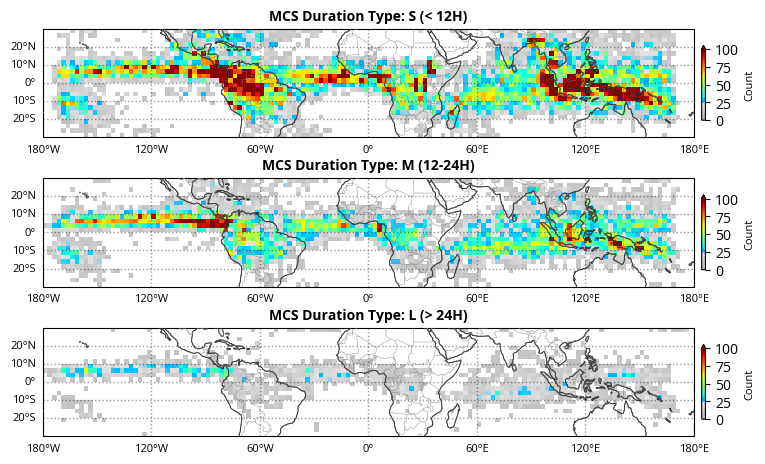

In [10]:
out_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds = xr.open_dataset(out_dir / 'MCS_non2mcs_frequency_SMLduraton.nc')

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,5.5),subplot_kw={'projection': ccrs.PlateCarree()})

for (ax, d_type, d_string) in zip([ax1,ax2,ax3],['S','M','L'],['(< 12H)', '(12-24H)', '(> 24H)']):

    ax.coastlines(color='k',linewidth=0.7)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

    ds_rm0 = ds.frequency.where(ds.frequency > 5)
    cp = ax.pcolormesh(ds_rm0.lon+1.25, ds_rm0.lat+1.25, ds_rm0.sel(duration_type=d_type), 
                        vmin=0, vmax=100, cmap=mixedmap)
    cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.01, extend="max")
    cp.cmap.set_over("darkred")
    cbar.set_label('Count',fontsize=8)
    cbar.set_ticks([0,25,50,75,100])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='k', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k'}
    
    ax.set_title('MCS Duration Type: {} {}'.format(d_type, d_string), fontsize=10, fontweight='bold')

In [16]:
%%time
# BL+, BL mean, mcs duration

duration_bins = np.linspace(0,80,41)
duration_samples = np.zeros((5,4,len(duration_bins)-1))
BL_TOT_mcs_quartile = np.zeros(4)

year_list = np.arange(2014,2019)

for year in year_list:
    #print('processing year : {}'.format(year))
    featstats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')
    
    data_feat = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    for p, phase in enumerate(data_feat.mcs_phase.values):
        # select BL at the initial phase
        BL_TOT_mcs = 340*3/9.8*data_feat.BL_TOT_mcs.sel(mcs_phase=phase) # (K)
        BL_sort = BL_TOT_mcs.sortby(BL_TOT_mcs) 

        # divide into quartiles
        total_tracks = len(BL_sort.tracks)
        for n in range(4): # 0-25%, 25-50%, 50-75%, 75-100%
            tracks_sel = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).tracks.values 
            duration_quartile = data_feat.sel(tracks=tracks_sel).mcs_duration
            BL_TOT_mcs_quartile[n] = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).mean('tracks')

            for mcs_duration in duration_quartile.values:
                idx = np.argmin(abs(mcs_duration - duration_bins))
                try:
                    duration_samples[p,n,idx] += 1
                except:
                    continue

CPU times: user 2.28 s, sys: 18.7 ms, total: 2.3 s
Wall time: 2.3 s


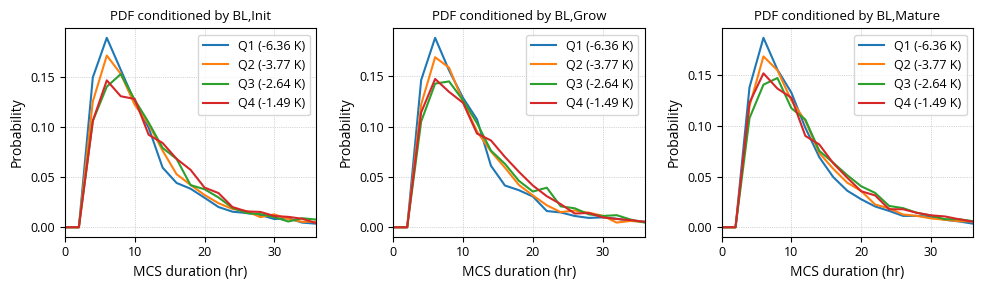

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

for p,(ax,phase_str) in enumerate(zip([ax1,ax2,ax3],['Init','Grow','Mature'])):
    for (n, q_str) in zip(range(4), ['Q1','Q2','Q3','Q4']):
        ax.plot(duration_bins[:-1], duration_samples[p,n,:]/np.sum(duration_samples[p,n,:])
                , label='{} ({} K)'.format(q_str,np.round(BL_TOT_mcs_quartile[n],decimals=2)))
    ax.set_xlim([0,36])
    ax.set_xlabel('MCS duration (hr)', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=9)
    ax.tick_params(labelsize=9)
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_title('PDF conditioned by BL,{}'.format(phase_str),fontsize=9.5)
    
plt.tight_layout()

In [25]:
%%time
# BL+, BL mean, mcs duration

duration_bins = np.linspace(0,80,41)
duration_samples = np.zeros((5,4,len(duration_bins)-1))
BL_TOT_mcs_quartile = np.zeros(4)

year_list = np.arange(2014,2019)

for year in year_list:
    #print('processing year : {}'.format(year))
    featstats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')
    
    data_feat = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    for p, phase in enumerate(data_feat.mcs_phase.values):
        # select BL at the initial phase
        BL_TOT_mcs = 340*3/9.8*data_feat.BL_positive_fraction.sel(mcs_phase=phase) # (K)
        BL_sort = BL_TOT_mcs.sortby(BL_TOT_mcs) 

        # divide into quartiles
        total_tracks = len(BL_sort.tracks)
        for n in range(4): # 0-25%, 25-50%, 50-75%, 75-100%
            tracks_sel = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).tracks.values 
            duration_quartile = data_feat.sel(tracks=tracks_sel).mcs_duration
            BL_TOT_mcs_quartile[n] = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).mean('tracks')

            for mcs_duration in duration_quartile.values:
                idx = np.argmin(abs(mcs_duration - duration_bins))
                try:
                    duration_samples[p,n,idx] += 1
                except:
                    continue

CPU times: user 2.3 s, sys: 10.9 ms, total: 2.32 s
Wall time: 2.39 s


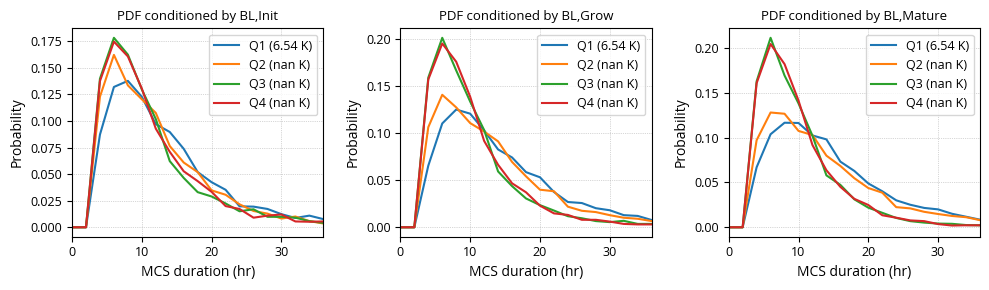

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

for p,(ax,phase_str) in enumerate(zip([ax1,ax2,ax3],['Init','Grow','Mature'])):
    for (n, q_str) in zip(range(4), ['Q1','Q2','Q3','Q4']):
        ax.plot(duration_bins[:-1], duration_samples[p,n,:]/np.sum(duration_samples[p,n,:])
                , label='{} ({} K)'.format(q_str,np.round(BL_TOT_mcs_quartile[n],decimals=2)))
    ax.set_xlim([0,36])
    ax.set_xlabel('MCS duration (hr)', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=9)
    ax.tick_params(labelsize=9)
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_title('PDF conditioned by BL,{}'.format(phase_str),fontsize=9.5)
    
plt.tight_layout()

In [27]:
data_feat

<xarray.Dataset>
Dimensions:               (tracks: 2916, mcs_phase: 5)
Coordinates:
  * tracks                (tracks) int64 44 56 65 70 ... 34160 34162 34181 34183
  * mcs_phase             (mcs_phase) object 'Init' 'Grow' ... 'Decay' 'End'
Data variables: (12/17)
    mcs_duration          (tracks) int64 ...
    BL_positive_area      (tracks, mcs_phase) float64 ...
    BL_positive_fraction  (tracks, mcs_phase) float64 ...
    BL_TOT_bp             (tracks, mcs_phase) float64 ...
    BL_TOT_mcs            (tracks, mcs_phase) float64 ...
    BL_CAPE_mcs           (tracks, mcs_phase) float64 ...
    ...                    ...
    mtpr_mcs              (tracks, mcs_phase) float64 ...
    corr_coeff_space      (tracks, mcs_phase) float64 ...
    corr_coeff_temp       (tracks) float64 ...
    ccs_area              (tracks, mcs_phase) float32 ...
    core_area             (tracks, mcs_phase) float32 ...
    cold_area             (tracks, mcs_phase) float32 ...
Attributes:
    long_name:  Duration of MCS stage
    units:      unitless
    comments:   Multiply by time_resolution_hour to convert to physical units